![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# 3. Training and Reusing Named Entity Recognition Models

## Related blogposts and videos:

https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77

NerDL worksghop (90 min): https://www.youtube.com/watch?v=YM-e4eOiQ34

https://medium.com/spark-nlp/named-entity-recognition-for-healthcare-with-sparknlp-nerdl-and-nercrf-a7751b6ad571

https://medium.com/atlas-research/ner-for-clinical-text-7c73caddd180

In [0]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)

spark

Spark NLP version 3.1.0
Apache Spark version: 3.1.1
Out[1]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.1 
 Master 
 spark://10.139.64.4:7077 
 AppName 
 Databricks Shell

## CoNLL Data Prep

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.train
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.testa

In [0]:
with open("eng.train") as f:
    train_txt =f.read()

print (train_txt[:500])

-DOCSTART- -X- -X- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER

BRUSSELS NNP B-NP B-LOC
1996-08-22 CD I-NP O

The DT B-NP O
European NNP I-NP B-ORG
Commission NNP I-NP I-ORG
said VBD B-VP O
on IN B-PP O
Thursday NNP B-NP O
it PRP B-NP O
disagreed VBD B-VP O
with IN B-PP O
German JJ B-NP B-MISC
advice NN I-NP O
to TO B-PP O
consumers NNS B-NP

In [0]:
from sparknlp.training import CoNLL

training_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.train')

training_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
EU rejects German...|[{document, 0, 47...|[{document, 0, 47...|[{token, 0, 1, EU...|[{pos, 0, 1, NNP,...|[{named_entity, 0...|
 Peter Blackburn|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 4, Pe...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
 BRUSSELS 1996-08-22|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 7, BR...|[{pos, 0, 7, NNP,...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
training_data.printSchema()

root
-- text: string (nullable = true)
-- document: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- sentence: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- token: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- pos: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- label: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)

In [0]:
training_data.count()

Out[6]: 14041

In [0]:
training_data.cache()

Out[7]: DataFrame[text: string, document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, sentence: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, token: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, pos: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, label: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>]

In [0]:
%time training_data.count()

CPU times: user 1.36 ms, sys: 620 µs, total: 1.98 ms
Wall time: 1.19 s
Out[8]: 14041

In [0]:
%time training_data.count()

CPU times: user 120 µs, sys: 55 µs, total: 175 µs
Wall time: 303 ms
Out[9]: 14041

In [0]:
import pyspark.sql.functions as F

training_data.select(F.explode(F.arrays_zip('token.result', 'pos.result',  'label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("pos"),
        F.expr("cols['2']").alias("ner_label")).show(truncate=50)

+----------+---+---------+
 token|pos|ner_label|
+----------+---+---------+
 EU|NNP| B-ORG|
 rejects|VBZ| O|
 German| JJ| B-MISC|
 call| NN| O|
 to| TO| O|
 boycott| VB| O|
 British| JJ| B-MISC|
 lamb| NN| O|
 .| .| O|
 Peter|NNP| B-PER|
 Blackburn|NNP| I-PER|
 BRUSSELS|NNP| B-LOC|
1996-08-22| CD| O|
 The| DT| O|
 European|NNP| B-ORG|
Commission|NNP| I-ORG|
 said|VBD| O|
 on| IN| O|
 Thursday|NNP| O|
 it|PRP| O|
+----------+---+---------+
only showing top 20 rows

In [0]:
training_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+------------+------+
ground_truth|count |
+------------+------+
O |169578|
B-LOC |7140 |
B-PER |6600 |
B-ORG |6321 |
I-PER |4528 |
I-ORG |3704 |
B-MISC |3438 |
I-LOC |1157 |
I-MISC |1155 |
+------------+------+

In [0]:
# You can use any word embeddings you want (Glove, Elmo, Bert, custom etc.)

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")
    

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ][OK!]

In [0]:
!mkdir ner_logs

In [0]:
nerTagger = NerDLApproach()\
  .setInputCols(["sentence", "token", "embeddings"])\
  .setLabelColumn("label")\
  .setOutputCol("ner")\
  .setMaxEpochs(1)\
  .setLr(0.003)\
  .setBatchSize(32)\
  .setRandomSeed(0)\
  .setVerbose(1)\
  .setValidationSplit(0.2)\
  .setEvaluationLogExtended(True) \
  .setEnableOutputLogs(True)\
  .setIncludeConfidence(True)\
  .setOutputLogsPath('ner_logs') # if not set, logs will be written to ~/annotator_logs
 #.setGraphFolder('graphs') >> put your graph file (pb) under this folder if you are using a custom graph generated thru 4.1 NerDL-Graph.ipynb notebook
 # .setEnableMemoryOptimizer() >> if you have a limited memory and a large conll file, you can set this True to train batch by batch 
    
ner_pipeline = Pipeline(stages=[
          glove_embeddings,
          nerTagger
 ])


### Fitting

In [0]:
ner_model = ner_pipeline.fit(training_data)

# 1 epoch takes around 1.5 min with batch size=32
# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook to create a graph (or see the bottom cell of this notebook)

In [0]:
%sh cd /databricks/driver/ner_logs && pwd && ls -l

/databricks/driver/ner_logs
total 4
-rw-r--r-- 1 root root 1003 Jul 9 20:29 NerDLApproach_b3a82b5ed31a.log

In [0]:
%sh head -n 45 ner_logs/NerDLApproach_b3a82b5ed31a.log

Name of the selected graph: ner-dl/blstm_10_100_128_120.pb
Training started - total epochs: 1 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 84 - training examples: 11275


Epoch 1/1 started, lr: 0.003, dataset size: 11275


Epoch 1/1 - 36.49s - loss: 1357.0396 - batches: 354
Quality on validation dataset (20.0%), validation examples = 2255
time to finish evaluation: 6.67s
label tp fp fn prec rec f1
B-LOC 1327 140 111 0.9045671 0.9228095 0.9135973
I-ORG 651 153 141 0.8097015 0.8219697 0.8157895
I-MISC 119 21 101 0.85 0.5409091 0.6611111
I-LOC 175 36 59 0.8293839 0.74786323 0.78651685
I-PER 865 66 21 0.9291085 0.976298 0.9521189
B-MISC 523 69 140 0.8834459 0.7888386 0.8334661
B-ORG 1084 157 193 0.87348914 0.84886456 0.86100084
B-PER 1214 151 62 0.8893773 0.95141065 0.9193488
tp: 5958 fp: 793 fn: 828 labels: 8
Macro-average prec: 0.8711341, rec: 0.8248704, f1: 0.8473713
Micro-average prec: 0.88253593, rec: 0.8779841, f1: 0.88025415

In [0]:
from sparknlp.training import CoNLL

test_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.testa')

test_data = glove_embeddings.transform(test_data)

test_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label| embeddings|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
CRICKET - LEICEST...|[{document, 0, 64...|[{document, 0, 64...|[{token, 0, 6, CR...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|[{word_embeddings...|
 LONDON 1996-08-30|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 5, LO...|[{pos, 0, 5, NNP,...|[{named_entity, 0...|[{word_embeddings...|
West Indian all-r...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 3, We...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|[{word_embeddings...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
predictions = ner_model.transform(test_data)
predictions.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label| embeddings| ner|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
CRICKET - LEICEST...|[{document, 0, 64...|[{document, 0, 64...|[{token, 0, 6, CR...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
 LONDON 1996-08-30|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 5, LO...|[{pos, 0, 5, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
West Indian all-r...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 3, We...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
predictions.select('token.result','label.result','ner.result').show(3, truncate=50)

+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
 result| result| result|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
[CRICKET, -, LEICESTERSHIRE, TAKE, OVER, AT, TO...| [O, O, B-ORG, O, O, O, O, O, O, O, O]| [O, O, B-ORG, O, O, O, O, O, O, O, O]|
 [LONDON, 1996-08-30]| [B-LOC, O]| [B-LOC, O]|
[West, Indian, all-rounder, Phil, Simmons, took...|[B-MISC, I-MISC, O, B-PER, I-PER, O, O, O, O, O...|[B-LOC, I-LOC, O, B-PER, I-PER, O, O, O, O, O, ...|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
only showing top 3 rows

### Test set evaluation

In [0]:
import pyspark.sql.functions as F

predictions.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth"),
        F.expr("cols['2']").alias("prediction")).show(truncate=False)

+--------------+------------+----------+
token |ground_truth|prediction|
+--------------+------------+----------+
CRICKET |O |O |
- |O |O |
LEICESTERSHIRE|B-ORG |B-ORG |
TAKE |O |O |
OVER |O |O |
AT |O |O |
TOP |O |O |
AFTER |O |O |
INNINGS |O |O |
VICTORY |O |O |
. |O |O |
LONDON |B-LOC |B-LOC |
1996-08-30 |O |O |
West |B-MISC |B-LOC |
Indian |I-MISC |I-LOC |
all-rounder |O |O |
Phil |B-PER |B-PER |
Simmons |I-PER |I-PER |
took |O |O |
four |O |O |
+--------------+------------+----------+
only showing top 20 rows

Licensed user will have an access to internal NERDLMetrics module to do this more efficient and easily without going out of Spark. But open source users need to use sklearen.mnetrics or any other equivalent module to do the same.

In [0]:
from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth"),
        F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction']))


precision recall f1-score support

 B-LOC 0.90 0.92 0.91 1837
 B-MISC 0.89 0.79 0.84 922
 B-ORG 0.85 0.83 0.84 1341
 B-PER 0.91 0.96 0.94 1842
 I-LOC 0.78 0.77 0.77 257
 I-MISC 0.84 0.54 0.66 346
 I-ORG 0.81 0.73 0.77 751
 I-PER 0.94 0.97 0.96 1307
 O 0.99 1.00 0.99 42759

 accuracy 0.97 51362
 macro avg 0.88 0.83 0.85 51362
weighted avg 0.97 0.97 0.97 51362

### Entity level evaluation (strict eval)

In [0]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/conll_eval.py
  
import sys

# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('/databricks/driver/')
#sys.path.append('/databricks/driver/databricks_import_python_module/')
sys.path.append('/databricks/driver/conll_eval.py')

In [0]:
import conll_eval

metrics = conll_eval.evaluate(preds_df['ground_truth'].values, preds_df['prediction'].values)

processed 51362 tokens with 5942 phrases; found: 6121 phrases; correct: 5195.
accuracy: 87.35%; (non-O)
accuracy: 97.49%; precision: 84.87%; recall: 87.43%; FB1: 86.13
 LOC: precision: 87.93%; recall: 91.62%; FB1: 89.74 1914
 MISC: precision: 79.88%; recall: 74.95%; FB1: 77.34 865
 ORG: precision: 77.95%; recall: 79.34%; FB1: 78.64 1365
 PER: precision: 88.87%; recall: 95.39%; FB1: 92.01 1977

In [0]:
# micro, macro, avg
metrics[0]

Out[25]: (84.87175298153896, 87.42847526085494, 86.1311448230125)

In [0]:
import pandas as pd
pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])

Out[26]:

,entity,precision,recall,f1,support
0,LOC,87.931034,91.616766,89.736070,1914
1,MISC,79.884393,74.945770,77.336318,865
2,ORG,77.948718,79.343773,78.640059,1365
3,PER,88.872028,95.385451,92.013616,1977


### Splitting dataset into train and test

In [0]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.train')

(training_data, test_data) = conll_data.randomSplit([0.7, 0.3], seed = 100)

print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 9739
Test Dataset Count: 4302

In [0]:
glove_embeddings.transform(test_data).write.parquet('/nerdl_test.parquet')

In [0]:
nerTagger = NerDLApproach()\
  .setInputCols(["sentence", "token", "embeddings"])\
  .setLabelColumn("label")\
  .setOutputCol("ner")\
  .setMaxEpochs(5)\
  .setLr(0.003)\
  .setBatchSize(32)\
  .setRandomSeed(0)\
  .setVerbose(1)\
  .setValidationSplit(0.2)\
  .setEvaluationLogExtended(True) \
  .setEnableOutputLogs(True)\
  .setIncludeConfidence(True)\
  .setTestDataset('/nerdl_test.parquet')\
  .setOutputLogsPath('ner_logs') # if not set, logs will be written to ~/annotator_logs

ner_pipeline = Pipeline(stages=[
          glove_embeddings,
          nerTagger
 ])

ner_model = ner_pipeline.fit(training_data)

In [0]:
%sh cd ner_logs && ls -lt && pwd

total 20
-rw-r--r-- 1 root root 7794 Jul 9 20:43 NerDLApproach_126906109129.log
-rw-r--r-- 1 root root 7795 Jul 9 20:35 NerDLApproach_56b4d85c5753.log
-rw-r--r-- 1 root root 1003 Jul 9 20:29 NerDLApproach_b3a82b5ed31a.log
/databricks/driver/ner_logs

In [0]:
%sh cat ner_logs/NerDLApproach_126906109129.log

Name of the selected graph: ner-dl/blstm_10_100_128_120.pb
Training started - total epochs: 5 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 83 - training examples: 7816


Epoch 1/5 started, lr: 0.003, dataset size: 7816


Epoch 1/5 - 24.06s - loss: 1109.9348 - batches: 247
Quality on validation dataset (20.0%), validation examples = 1563
time to finish evaluation: 4.57s
label tp fp fn prec rec f1
B-LOC 918 209 59 0.8145519 0.9396111 0.8726235
I-ORG 316 65 177 0.8293963 0.6409736 0.7231121
I-MISC 67 25 83 0.7282609 0.44666666 0.55371904
I-LOC 140 95 17 0.59574467 0.89171976 0.71428573
I-PER 615 53 8 0.9206587 0.9871589 0.9527498
B-MISC 371 63 102 0.8548387 0.78435516 0.8180816
B-ORG 637 104 201 0.8596491 0.7601432 0.80683976
B-PER 867 75 66 0.92038214 0.92926043 0.92480004
tp: 3931 fp: 689 fn: 713 labels: 8
Macro-average prec: 0.8154353, rec: 0.7974861, f1: 0.80636084
Micro-average prec: 0.8508658, rec: 0.84646857, f1: 0.8486615
Quality on test dataset: 
time to finish evaluation: 9.52s
label tp fp fn prec rec f1
B-LOC 2025 474 134 0.81032413 0.9379342 0.8694719
I-ORG 775 169 372 0.8209746 0.6756757 0.7412722
I-MISC 169 26 210 0.8666667 0.4459103 0.58885014
I-LOC 294 216 55 0.5764706 0.84240687 0.6845169
I-PER 1417 93 29 0.9384106 0.97994465 0.95872796
B-MISC 800 148 247 0.84388185 0.76408786 0.802005
B-ORG 1450 272 476 0.8420441 0.75285566 0.7949561
B-PER 1930 158 112 0.9243295 0.9451518 0.93462473
tp: 8860 fp: 1556 fn: 1635 labels: 8
Macro-average prec: 0.8278878, rec: 0.79299587, f1: 0.8100663
Micro-average prec: 0.8506144, rec: 0.8442115, f1: 0.84740096


Epoch 2/5 started, lr: 0.0029850747, dataset size: 7816


Epoch 2/5 - 22.59s - loss: 353.95026 - batches: 247
Quality on validation dataset (20.0%), validation examples = 1563
time to finish evaluation: 4.46s
label tp fp fn prec rec f1
B-LOC 917 64 60 0.93476045 0.9385875 0.93667
I-ORG 391 44 102 0.89885056 0.79310346 0.8426724
I-MISC 88 27 62 0.76521736 0.58666664 0.6641509
I-LOC 138 19 19 0.8789809 0.8789809 0.8789809
I-PER 617 33 6 0.9492308 0.9903692 0.9693637
B-MISC 395 42 78 0.90389013 0.83509517 0.8681319
B-ORG 726 105 112 0.8736462 0.86634845 0.869982
B-PER 905 78 28 0.9206511 0.9699893 0.94467646
tp: 4177 fp: 412 fn: 467 labels: 8
Macro-average prec: 0.89065343, rec: 0.8573925, f1: 0.8737065
Micro-average prec: 0.9102201, rec: 0.8994401, f1: 0.904798
Quality on test dataset: 
time to finish evaluation: 9.54s
label tp fp fn prec rec f1
B-LOC 2000 182 159 0.9165903 0.92635477 0.9214466
I-ORG 894 130 253 0.8730469 0.7794246 0.8235836
I-MISC 220 45 159 0.8301887 0.5804749 0.6832298
I-LOC 278 66 71 0.80813956 0.7965616 0.80230886
I-PER 1417 62 29 0.95807976 0.97994465 0.9688889
B-MISC 855 81 192 0.91346157 0.8166189 0.8623298
B-ORG 1656 285 270 0.8531685 0.8598131 0.8564779
B-PER 1985 173 57 0.9198332 0.9720862 0.94523805
tp: 9305 fp: 1024 fn: 1190 labels: 8
Macro-average prec: 0.88406354, rec: 0.83890986, f1: 0.86089504
Micro-average prec: 0.9008617, rec: 0.88661265, f1: 0.89368033


Epoch 3/5 started, lr: 0.0029702971, dataset size: 7816


Epoch 3/5 - 22.46s - loss: 252.30849 - batches: 247
Quality on validation dataset (20.0%), validation examples = 1563
time to finish evaluation: 4.14s
label tp fp fn prec rec f1
B-LOC 942 98 35 0.9057692 0.96417606 0.93406045
I-ORG 367 22 126 0.9434447 0.7444219 0.8321995
I-MISC 111 54 39 0.6727273 0.74 0.70476186
I-LOC 144 44 13 0.7659575 0.91719747 0.83478266
I-PER 611 9 12 0.9854839 0.98073834 0.98310536
B-MISC 417 66 56 0.863354 0.88160676 0.8723849
B-ORG 714 72 124 0.90839696 0.85202867 0.8793104
B-PER 887 31 46 0.9662309 0.9506967 0.9584009
tp: 4193 fp: 396 fn: 451 labels: 8
Macro-average prec: 0.87642056, rec: 0.8788582, f1: 0.8776377
Micro-average prec: 0.91370666, rec: 0.90288544, f1: 0.90826386
Quality on test dataset: 
time to finish evaluation: 9.81s
label tp fp fn prec rec f1
B-LOC 2060 250 99 0.8917749 0.95414543 0.9219065
I-ORG 859 75 288 0.9197002 0.7489102 0.8255647
I-MISC 292 73 87 0.8 0.77044857 0.78494626
I-

In [0]:
test_data = glove_embeddings.transform(test_data)

predictions = ner_model.transform(test_data)

from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth"),
        F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction'], digits=4))


precision recall f1-score support

 B-LOC 0.9557 0.9389 0.9472 2159
 B-MISC 0.9172 0.8883 0.9025 1047
 B-ORG 0.8981 0.9107 0.9044 1926
 B-PER 0.9679 0.9736 0.9707 2042
 I-LOC 0.8559 0.8510 0.8534 349
 I-MISC 0.8788 0.7652 0.8181 379
 I-ORG 0.8805 0.8928 0.8866 1147
 I-PER 0.9855 0.9848 0.9851 1446
 O 0.9953 0.9966 0.9959 52122

 accuracy 0.9850 62617
 macro avg 0.9261 0.9113 0.9182 62617
weighted avg 0.9849 0.9850 0.9849 62617

### Ner log parser

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py
  
sys.path.append('/databricks/driver/ner_log_parser.py')

In [0]:
import ner_log_parser

In [0]:
%matplotlib inline

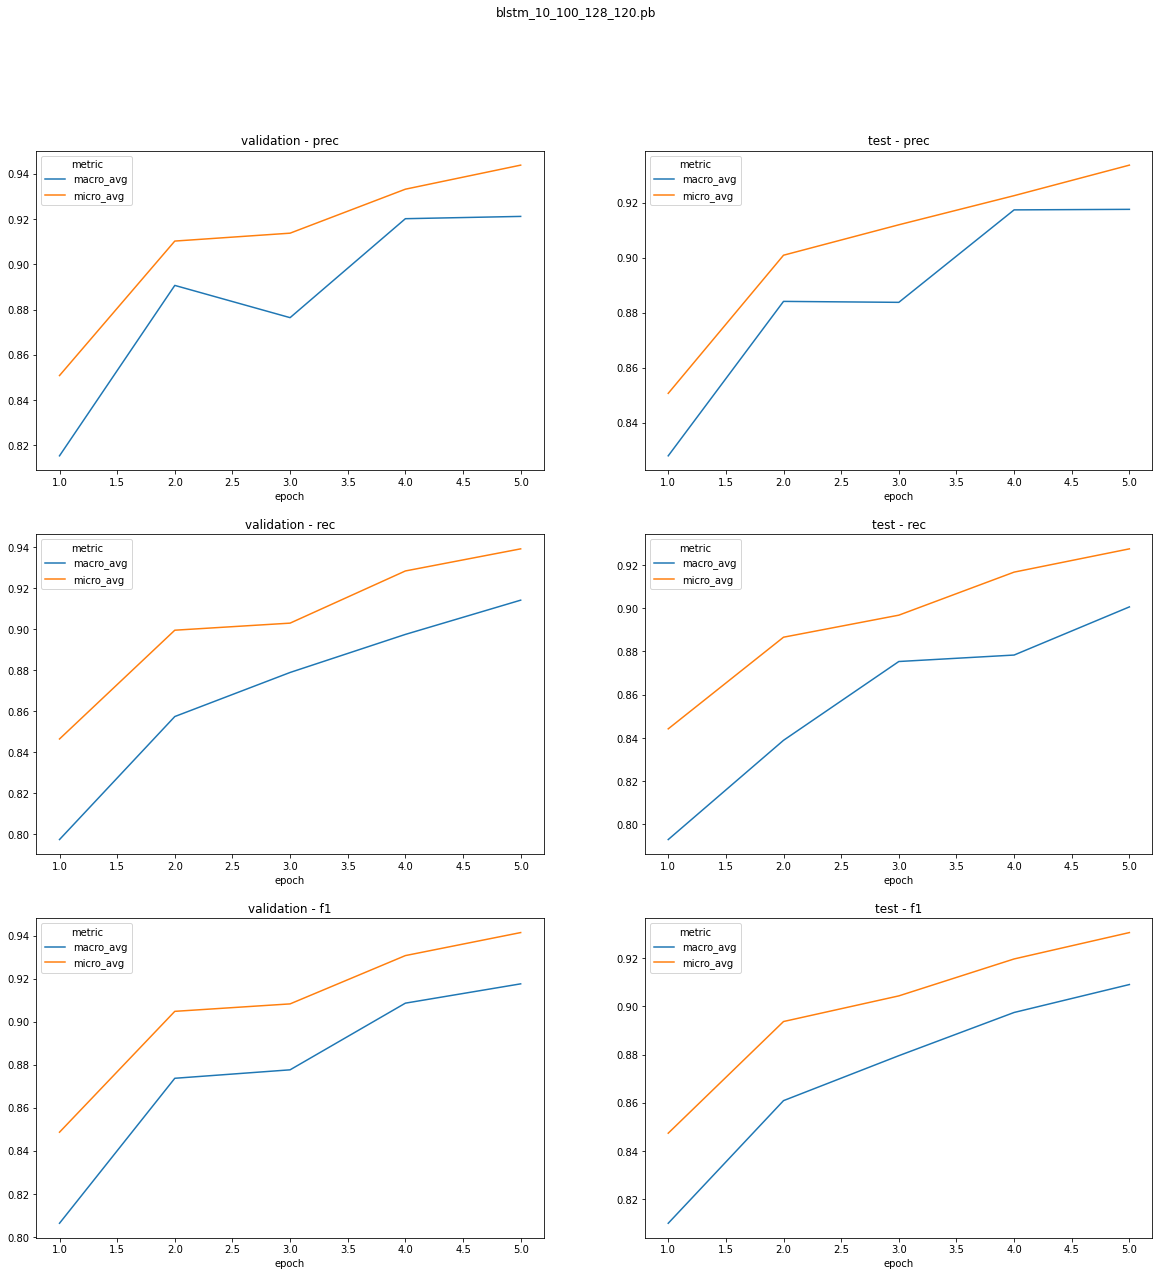

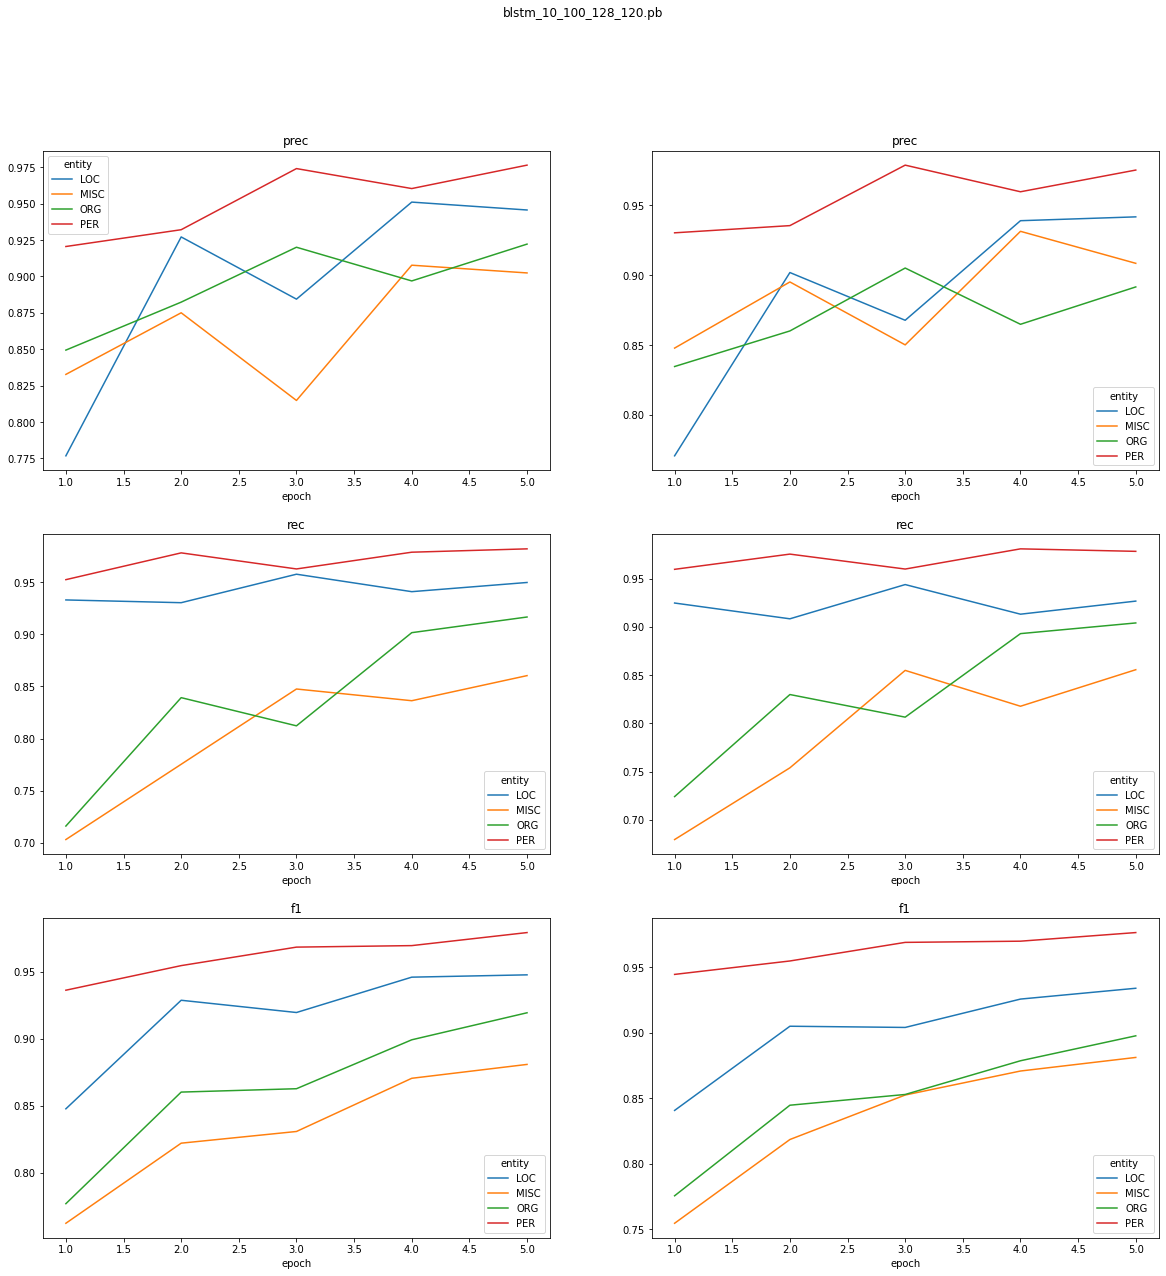

In [0]:
ner_log_parser.get_charts('/databricks/driver/ner_logs/NerDLApproach_126906109129.log')

**Plotting Loss**

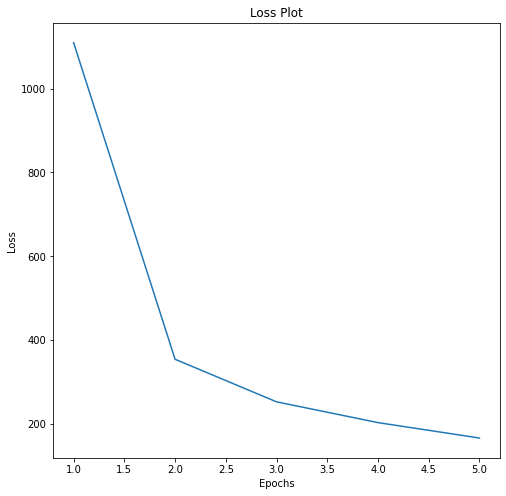

In [0]:
ner_log_parser.loss_plot('/databricks/driver/ner_logs/NerDLApproach_126906109129.log')

### Saving the trained model

In [0]:
ner_model.stages

Out[44]: [WORD_EMBEDDINGS_MODEL_48cffc8b9a76, NerDLModel_98d51202cc7f]

In [0]:
%sh cd /databricks/driver/ && ls -la

total 10184
drwxr-xr-x 1 root root 4096 Jul 9 21:15 .
drwxr-xr-x 1 root root 4096 Jul 9 19:45 ..
drwxr-xr-x 2 root root 4096 Jul 9 21:15 __pycache__
drwxr-xr-x 2 root root 4096 Jan 1 1970 conf
-rw-r--r-- 1 root root 7431 Jul 9 20:31 conll_eval.py
-rw-r--r-- 1 root root 827443 Jul 9 20:27 eng.testa
-rw-r--r-- 1 root root 3283420 Jul 9 20:27 eng.train
drwxr-xr-x 3 root root 4096 Jul 9 19:45 eventlogs
drwxr-xr-x 2 root root 4096 Jul 9 21:15 ganglia
drwxr-xr-x 2 root root 4096 Jul 9 21:01 logs
-rw-r--r-- 1 root root 3826 Jul 9 21:15 ner_log_parser.py
drwxr-xr-x 2 root root 4096 Jul 9 20:39 ner_logs
-r-xr-xr-x 1 root root 750334 Jan 1 1970 preload_class.lst
-rw-r--r-- 1 root root 284 Jul 9 21:12 sample-sentences-en.txt
-rw-r--r-- 1 root root 5502589 Jul 9 20:40 spam_ham_dataset.csv

In [0]:
ner_model.stages[1].write().overwrite().save('/databricks/driver/models/NerDLModel_3010')

In [0]:
%fs ls /databricks/driver/models

path,name,size
dbfs:/databricks/driver/models/ClassifierDL_wordemb_g100d/,ClassifierDL_wordemb_g100d/,0
dbfs:/databricks/driver/models/ClassifierDL_wordemb_g100d.model/,ClassifierDL_wordemb_g100d.model/,0
dbfs:/databricks/driver/models/GenericClassifierModel_trained/,GenericClassifierModel_trained/,0
dbfs:/databricks/driver/models/NER_glove_e1_b32/,NER_glove_e1_b32/,0
dbfs:/databricks/driver/models/NerDLModel_3010/,NerDLModel_3010/,0


## Prediction Pipeline

In [0]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
    .setInputCols(["document", "token"])\
    .setOutputCol("embeddings")
    
loaded_ner_model = NerDLModel.load("/databricks/driver/models/NerDLModel_3010")\
     .setInputCols(["sentence", "token", "embeddings"])\
     .setOutputCol("ner")

converter = NerConverter()\
      .setInputCols(["document", "token", "ner"])\
      .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(
    stages = [
        document,
        sentence,
        token,
        glove_embeddings,
        loaded_ner_model,
        converter])

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ][OK!]

In [0]:
empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)


In [0]:
text = "Peter Parker is a nice guy and lives in New York."

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=False)

+-------------------------------------------------+
text |
+-------------------------------------------------+
Peter Parker is a nice guy and lives in New York.|
+-------------------------------------------------+

In [0]:
preds = prediction_model.transform(sample_data)

preds.select(F.explode(F.arrays_zip("ner_span.result","ner_span.metadata")).alias("entities")) \
.select(F.expr("entities['0']").alias("chunk"),
        F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

+------------+------+
chunk |entity|
+------------+------+
Peter Parker|PER |
New York |LOC |
+------------+------+

In [0]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

In [0]:
text = "Peter Parker is a nice guy and lives in New York."

result = light_model.annotate(text)

list(zip(result['token'], result['ner']))

Out[53]: [('Peter', 'B-PER'),
 ('Parker', 'I-PER'),
 ('is', 'O'),
 ('a', 'O'),
 ('nice', 'O'),
 ('guy', 'O'),
 ('and', 'O'),
 ('lives', 'O'),
 ('in', 'O'),
 ('New', 'B-LOC'),
 ('York', 'I-LOC'),
 ('.', 'O')]

In [0]:
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df

Out[54]:

,sent_id,token,start,end,ner
0,0,Peter,0,4,B-PER
1,0,Parker,6,11,I-PER
2,0,is,13,14,O
3,0,a,16,16,O
4,0,nice,18,21,O
5,0,guy,23,25,O
6,0,and,27,29,O
7,0,lives,31,35,O
8,0,in,37,38,O
9,0,New,40,42,B-LOC


# Creating your own CoNLL dataset

for a detailed overview of how to create a CoNLL file from any annotation, see here >> https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.3.prepare_CoNLL_from_annotations_for_NER.ipynb

In [0]:
import json
import os
from pyspark.ml import Pipeline
from sparknlp.base import *
from sparknlp.annotator import *
import sparknlp

spark = sparknlp.start()

def get_ann_pipeline ():
    
    document_assembler = DocumentAssembler() \
        .setInputCol("text")\
        .setOutputCol('document')

    tokenizer = Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")

    pos = PerceptronModel.pretrained() \
              .setInputCols(["sentence", "token"]) \
              .setOutputCol("pos")
    
    embeddings = WordEmbeddingsModel.pretrained()\
          .setInputCols(["sentence", "token"])\
          .setOutputCol("embeddings")

    ner_model = NerDLModel.pretrained() \
          .setInputCols(["sentence", "token", "embeddings"]) \
          .setOutputCol("ner")

    ner_converter = NerConverter()\
      .setInputCols(["sentence", "token", "ner"])\
      .setOutputCol("ner_chunk")

    ner_pipeline = Pipeline(
        stages = [
            document_assembler,
            sentence,
            tokenizer,
            pos,
            embeddings,
            ner_model,
            ner_converter
        ]
    )

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    ner_pipelineFit = ner_pipeline.fit(empty_data)

    ner_lp_pipeline = LightPipeline(ner_pipelineFit)

    print ("Spark NLP NER lightpipeline is created")

    return ner_lp_pipeline


conll_pipeline = get_ann_pipeline ()



pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[ | ][ / ][ — ][ \ ][OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ][OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][OK!]
Spark NLP NER lightpipeline is created

In [0]:
sentences = ["Peter Parker is a nice guy and lives in New York.",
"He is also helping people around the world."]

conll_lines=''

for sentence in sentences:

  parsed = conll_pipeline.annotate (sentence)

  for token, pos, ner in zip(parsed['token'],parsed['pos'],parsed['ner']):

      conll_lines += "{} {} {} {}\n".format(token, pos, pos, ner)

  conll_lines += '\n'


print(conll_lines)

Peter NNP NNP B-PER
Parker NNP NNP I-PER
is VBZ VBZ O
a DT DT O
nice JJ JJ O
guy NN NN O
and CC CC O
lives NNS NNS O
in IN IN O
New NNP NNP B-LOC
York NNP NNP I-LOC
. . . O

He PRP PRP O
is VBZ VBZ O
also RB RB O
helping VBG VBG O
people NNS NNS O
around IN IN O
the DT DT O
world NN NN O
. . . O

# NerDL Graph

Licensed users would use this module to create graphs for each DL model (`ner_dl`, `generic_classifier`, `assertion_dl`, `relation_extraction`) in Spark NLP but in open source, you need to run the other cell.

```
%tensorflow_version 1.x

from sparknlp_jsl.training import tf_graph

tf_graph.build("ner_dl", build_params={"embeddings_dim": 200, "nchars": 80, "ntags": 12}, model_location="./", model_filename="auto")
```

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/create_graph.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/dataset_encoder.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model_saver.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/sentence_grouper.py
import sys
sys.path.append('/databricks/driver/')
sys.path.append('/databricks/driver/create_graph.py')
import create_graph
ntags = 19 # number of labels
embeddings_dim = 100
nchars =100
create_graph.create_graph(ntags, embeddings_dim, nchars)

In [0]:
%sh
ls -lt

total 10212
drwxr-xr-x 2 root root 4096 Jul 9 21:38 __pycache__
-rw-r--r-- 1 root root 953 Jul 9 21:38 sentence_grouper.py
-rw-r--r-- 1 root root 2484 Jul 9 21:38 ner_model_saver.py
-rw-r--r-- 1 root root 21853 Jul 9 21:38 ner_model.py
-rw-r--r-- 1 root root 2543 Jul 9 21:38 dataset_encoder.py
-rw-r--r-- 1 root root 1545 Jul 9 21:38 create_graph.py
drwxr-xr-x 2 root root 4096 Jul 9 21:30 ganglia
-rw-r--r-- 1 root root 3826 Jul 9 21:15 ner_log_parser.py
-rw-r--r-- 1 root root 284 Jul 9 21:12 sample-sentences-en.txt
drwxr-xr-x 2 root root 4096 Jul 9 21:01 logs
-rw-r--r-- 1 root root 5502589 Jul 9 20:40 spam_ham_dataset.csv
drwxr-xr-x 2 root root 4096 Jul 9 20:39 ner_logs
-rw-r--r-- 1 root root 7431 Jul 9 20:31 conll_eval.py
-rw-r--r-- 1 root root 827443 Jul 9 20:27 eng.testa
-rw-r--r-- 1 root root 3283420 Jul 9 20:27 eng.train
drwxr-xr-x 3 root root 4096 Jul 9 19:45 eventlogs
drwxr-xr-x 2 root root 4096 Jan 1 1970 conf
-r-xr-xr-x 1 root root 750334 Jan 1 1970 preload_class.lst

End of Notebook #